## Выберите две особенности в данных из приведенных ниже, сформулируйте для них гипотезы по всем правилам:
- В период Surge видим более низкую price-to-order конверсию
- Для устройств Android наблюдаем более высокие юзерские отмены
- Если Заказ из центра, то видим более низкие юзерские отмены
- Если Comfort & Business классы, то более низкие юзерские отмены, более длинные поездки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../H1/new_dataframe.csv')
df.head()

,Unnamed: 0,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


### 1'st detail check - with surge price-to-order conversion is lower

In [2]:
df_pto = df.loc[df.price_seen == 1].groupby('surge')[['order_made', 'ride_completed', 'user_cancelled']].mean().copy()
df_pto

,order_made,ride_completed,user_cancelled
surge,,,
no surge,0.859085,0.729427,0.129658
surge,0.722845,0.611699,0.111146


That statement is true. `order_made` column shows exact percentage of orders

### 2'nd detail check - Center orders being cancelled less

In [3]:
df_cancels = df.groupby('city_center_order')[['order_made', 'user_cancelled', 'ride_completed']].mean().copy()
df_cancels

,order_made,user_cancelled,ride_completed
city_center_order,,,
0,0.684186,0.129546,0.554641
1,0.766756,0.097148,0.669608


That statement is true. Each column shows exact percentage of cancels and completions

### Forming hypothesis

| N | Гипотеза | Источник | Почему не стоит проверять | Личный рейтинг | Почему такая оценка |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1 | Если уменьшить стоимость при высоком спросе на 5%, то общая прибыль будет выше изначальной более чем на 5%, из за увеличения конверсий в оформление заказа после более комфортной увиденной цены  | Данные + Предположение | Риск потерять деньги | 8 | Требует либо дополнительных данных, либо тестирования, поскольку сказать однозначно невозможно |
| 2 | Если увеличить стоимость заказов из центра на 10%, то мы получим около 5% прибыли, поскольку данные заказы реже отменяются. Требуется параллельно следить за конверсией в заказ, чтобы не упала слишком сильно | Данные | Есть вероятность потери клиента и увеличения отказа после увиденной цены | 8 | Потому что таким образом мы можем отпугнуть клиентов в сторону конкурентов |

## Разбейте юзеров на группы с помощью рандома, например, по следующему алгориму:
- Добавьте новую колонку, где каждому юзеру присвойте значение функции RAND() - выдает случайное число от 0 до 1
- В зависимости от значения rand - поместите пользователя в группу 1 или 2. (если rand >0.5, то 1, иначе 2)

As earlier I will use `user_id` and `os` columns, as it is an identifier for a unique person, not an account

In [4]:
df_user = df.groupby(['user_id', 'os']).mean(numeric_only=True).copy()
df_user.head()

Unnamed: 0  hour  app_opened  price_seen  order_made  \
user_id os                                                                
100093  Android  85065.000000   4.0         1.0         1.0        1.00   
        iOS      48725.500000   8.0         1.0         1.0        0.50   
100118  Android  48286.500000  12.0         1.0         1.0        1.00   
        iOS      43184.333333  16.0         1.0         1.0        1.00   
100134  Android  59032.000000  16.0         1.0         1.0        0.75   

                 ride_completed  user_cancelled  city_center_order  distance  \
user_id os                                                                     
100093  Android             1.0            0.00               0.50  4.806005   
        iOS                 0.5            0.00               0.00  5.876673   
100118  Android             0.5            0.50               0.00  0.809886   
        iOS                 1.0            0.00               0.00  7.706738   
100134  Android             0.5            0.25               0.25  6.250777   

                  age  
user_id os             
100093  Android  21.0  
        iOS      21.0  
100118  Android  26.0  
        iOS      26.0  
100134  Android  25.0

In [5]:
# That cell randomizes values in ['random'] column and splits it in 2. Execute on your own risk =D
df_user['rand'] = df_user.apply(lambda row: np.random.rand(), axis=1)
df_usergroup1 = df_user.loc[df_user['rand'] > 0.5].drop(columns='rand')
df_usergroup2 = df_user.loc[df_user['rand'] <= 0.5].drop(columns='rand')
print('Группа 1 имеет размер =', len(df_usergroup1), '\nГруппа 2 имеет размер =', len(df_usergroup2))

Группа 1 имеет размер = 21410 
Группа 2 имеет размер = 21338


## Проверьте на однородность с помощью:
Рангового критерия (либо еще сложнее уровень) бакетинга/бутстрапа

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm
alpha = 0.05

In [7]:
# Данную функцию я пока использую из материалов наших по статистике, не вникнув до конца как ИМЕННО она работает
# Но она работает, потому не парюсь. Напишу впоследствии свою функцию, поскольку хочу понять в деталях
def get_bootstrap(
    data_column_1,                    # Числовые значения первой выборки
    data_column_2,                    # Числовые значения второй выборки
    boot_it = 500,                   # Количество бутстрэп-подвыборок
    statistic = np.mean,              # Интересующая нас статистика
    bootstrap_conf_level = 1-alpha    # Уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):    # Извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True            # Параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,                 # Чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    print('p-value: %.8f' % p_value)

    return p_value

Я не буду создавать новые группы, просто эти две проверю дважды на неоднородность

### 1'st Hypothesis - with surge price-to-order conversion is lower

Посчитаем по метрикам price_seen и order_made. В коде видно, что делю alpha на 2 для этого

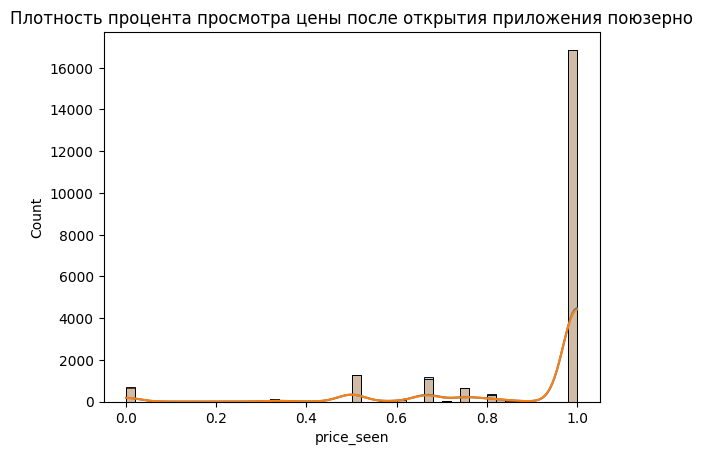

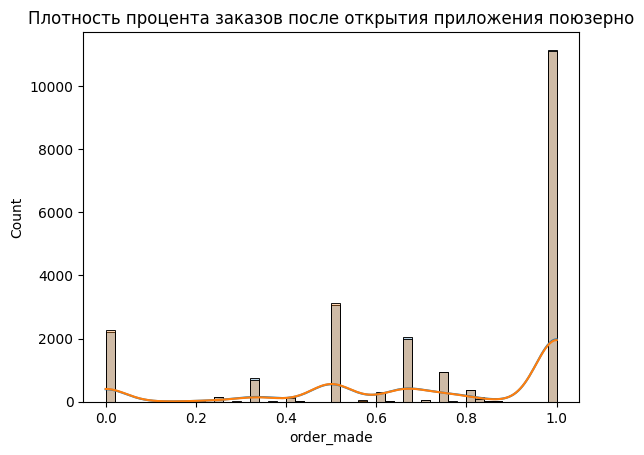

In [8]:
sns.histplot(df_usergroup1.price_seen, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.price_seen, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента просмотра цены после открытия приложения поюзерно')
plt.show()

sns.histplot(df_usergroup1.order_made, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.order_made, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента заказов после открытия приложения поюзерно')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

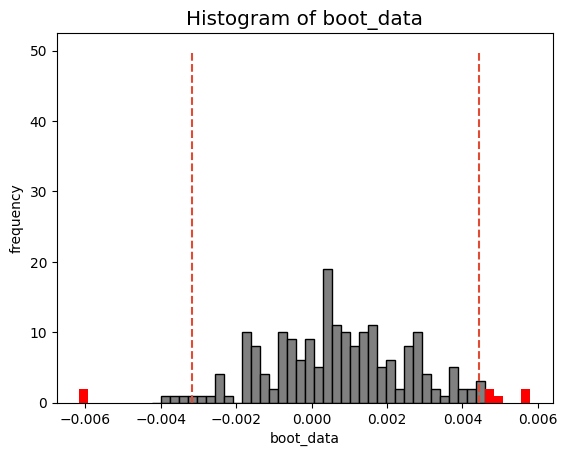

p-value: 0.72291663
Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически
значимая разница в соотношении увиденной цены ко входу в приложение


  0%|          | 0/200 [00:00<?, ?it/s]

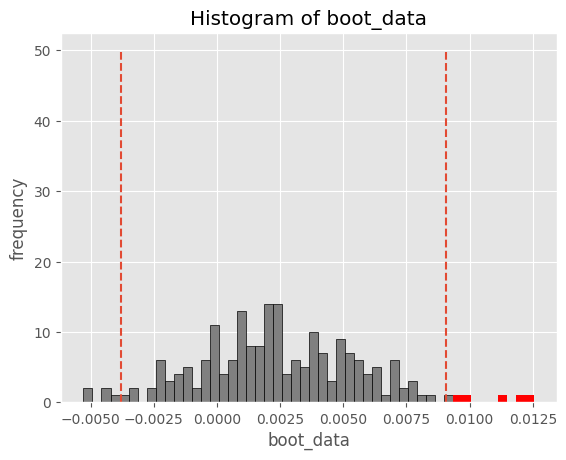

p-value: 0.44707657
Не отвергаем нулевую гипотезу. Между выборками остутствует статистически
значимая разница в соотношении количества сделанных заказов ко входу в приложение


In [9]:
tmp_boot1 = get_bootstrap(
    df_usergroup1.price_seen,                 # числовые значения первой выборки
    df_usergroup2.price_seen,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot1 < alpha/2):
    print('Отвергаем нулевую гипотезую. Между выборками присутствует статистически',
            'значимая разница в соотношении увиденной цены ко входу в приложение', sep='\n')
else:
    print('Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически',
            'значимая разница в соотношении увиденной цены ко входу в приложение', sep='\n')

tmp_boot2 = get_bootstrap(
    df_usergroup1.order_made,                 # числовые значения первой выборки
    df_usergroup2.order_made,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot2 < alpha/2):
    print('Отвергаем нулевую гипотезу. Между выборками присутствует статистически',
            'значимая разница в соотношении количества сделанных заказов ко входу в приложение', sep='\n')
else:
    print('Не отвергаем нулевую гипотезу. Между выборками остутствует статистически',
            'значимая разница в соотношении количества сделанных заказов ко входу в приложение', sep='\n')

### 2'nd Hypothesis - Center orders being cancelled less

Возьмем количество заказов из центра и количество отказов

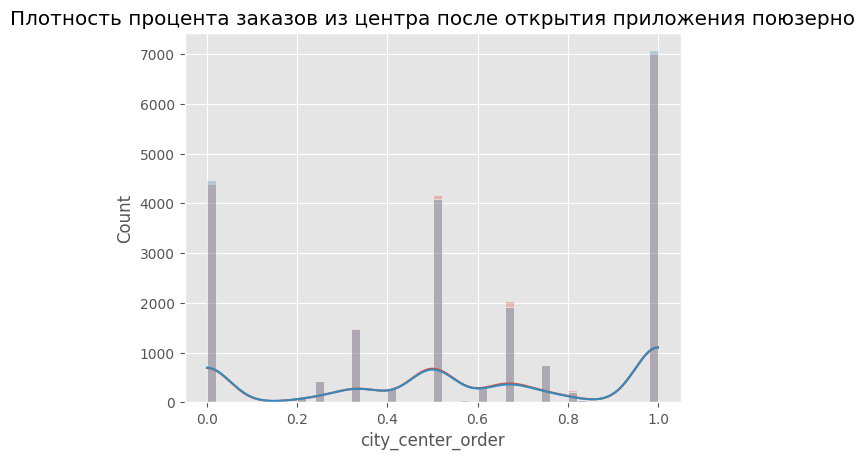

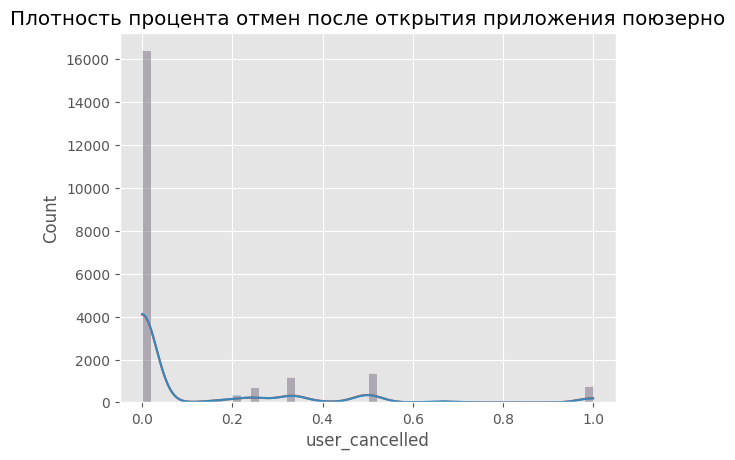

In [10]:
sns.histplot(df_usergroup1.city_center_order, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.city_center_order, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента заказов из центра после открытия приложения поюзерно')
plt.show()

sns.histplot(df_usergroup1.user_cancelled, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.user_cancelled, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента отмен после открытия приложения поюзерно')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

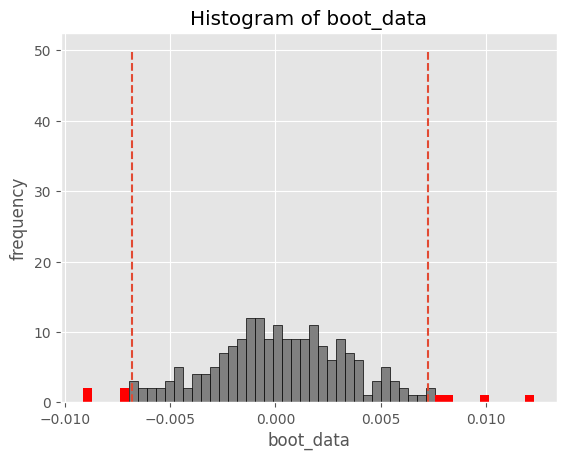

p-value: 0.94789186
Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически
значимая разница в соотношении заказов из центра ко входу в приложение


  0%|          | 0/200 [00:00<?, ?it/s]

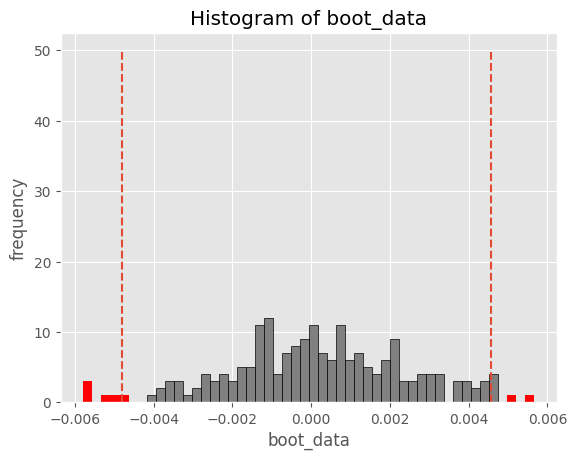

p-value: 0.94116596
Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически
значимая разница в соотношении отказов ко входу в приложение


In [11]:
tmp_boot1 = get_bootstrap(
    df_usergroup1.city_center_order,                 # числовые значения первой выборки
    df_usergroup1.city_center_order,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot1 < alpha/2):
    print('Отвергаем нулевую гипотезу. Между выборками присутствует статистически',
            'значимая разница в соотношении заказов из центра ко входу в приложение', sep='\n')
else:
    print('Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически',
            'значимая разница в соотношении заказов из центра ко входу в приложение', sep='\n')

tmp_boot2 = get_bootstrap(
    df_usergroup1.user_cancelled,                 # числовые значения первой выборки
    df_usergroup1.user_cancelled,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot2 < alpha/2):
    print('Отвергаем нулевую гипотезу. Между выборками присутствует статистически',
            'значимая разница в соотношении отказов ко входу в приложение', sep='\n')
else:
    print('Не отвергаем нулевую гипотезу. Между выборками отсутствует статистически',
            'значимая разница в соотношении отказов ко входу в приложение', sep='\n')